In [1]:
import os

import pandas as pd
import numpy as np
import metrics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

import preprocessing

In [72]:
model = 'chargeDDEa'

In [53]:
!time g++ -Wall -std=c++11 -O3 src/*.cpp -o ./bin/sgd


real	0m4.109s
user	0m3.886s
sys	0m0.194s


In [54]:
!time ./bin/sgd data/mrh chargeDDEA

Loading config file : data/mrh/chargeDDEA.cfg
Lodading data file : data/mrh/features.dat
Lodading data file : data/mrh/exposure.dat
Lodading data file : data/mrh/target_chargeDDEm.dat
130071

Fit Model for 7 variables with 10000000 iterations :
0th iteration : rmse(train=1136.79, test=1147.65) | gini(train=0.0922209, test=0.0937742)
Diff of coeffs : inf
1813000th iteration : rmse(train=1110.23, test=1126.52) | gini(train=0.113807, test=0.106601)
Diff of coeffs : 0.00163407
1831130 : Removing AUTA_rm_7090 93  Norm2=1.02448e-05
1849260 : Removing AUTV_k8000_o 39  Norm2=1.5833e-05
1867390 : Removing AUTV_prix_sra_jl 43  Norm2=4.00927e-05
1885520 : Removing CLI_top_pju 116  Norm2=3.49424e-05
1903650 : Removing AUTV_nb_vol_gh 60  Norm2=7.76041e-05
1921780 : Removing AUTV_segment_m2 51  Norm2=4.94646e-05
1939910 : Removing AUTV_nb_vol_supk 62  Norm2=6.45763e-05
1958040 : Removing AUTV_rm 26  Norm2=9.11601e-06
1976170 : Removing AUTV_k8000_n 38  Norm2=7.23315e-05
1994300 : Removing AUTA_rm_su

4895100 : Removing Zone_inc_cm_iris 152  Norm2=0.00511269
4985750 : Removing ddea_quant_freq_20 138  Norm2=0.00546436
5076400 : Removing CLI_cspf 127  Norm2=0.00575653
5167050 : Removing HAB_cdresid 33  Norm2=0.00656192
5257700 : Removing vol_quant_cm_20 144  Norm2=0.0068487
5348350 : Removing HAB_habit_X_qual_X_inhab 124  Norm2=0.00719076
5439000th iteration : rmse(train=1116.46, test=1128.23) | gini(train=0.105517, test=0.103686)
Diff of coeffs : 0.00153484
5439000 : Removing HAB_habit_nbpieces 149  Norm2=0.00750319
5529650 : Removing POL_distrib_code 151  Norm2=0.00789155
5620300 : Removing CLI_banque 29  Norm2=0.00831993
5710950 : Removing ddem_quant_cm_20 141  Norm2=0.00913805
5801600 : Removing HAB_nb_pieces 85  Norm2=0.00962894
5892250 : Removing HAB_inhab 97  Norm2=0.0107109
7252000th iteration : rmse(train=1119.56, test=1130.49) | gini(train=0.101335, test=0.101418)
Diff of coeffs : 0.00069536
9065000th iteration : rmse(train=1119.15, test=1129.97) | gini(train=0.102107, test=

mean: 1241.210429 1228.304548
rmse: 1129.960145
gini: 0.10232503841554375
deviance: 16.84941088114567


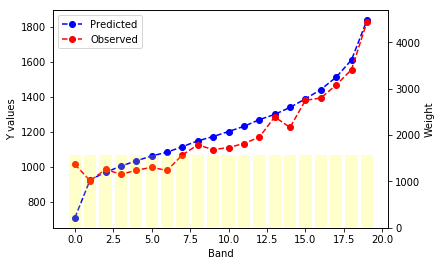

In [66]:
df = pd.read_csv("./data/results.csv")
print('mean:', round(np.sum(df.prediction) / np.sum(df.exposure), 6), round(np.sum(df.target) / np.sum(df.exposure), 6))
print('rmse:', round(metrics.root_mean_square_error(df.target, df.prediction, df.exposure), 6))
print('gini:', metrics.gini_emblem_fast(df.target, df.prediction, df.exposure))
print('deviance:', np.log(metrics.poisson_deviance(df.target, df.prediction, df.exposure)))
metrics.plot_lift_curve(df.target, df.prediction, df.exposure, n_band=20)

In [56]:
metadata = preprocessing.Metadata("data", "mrh")
metadata.load()

Loaded metadata from  data/mrh/metadata.json


In [57]:
n = metadata.size
p = metadata.count_features()


def load_data(file_path, dtype='int32', shape=None):
    return np.memmap(file_path, dtype=dtype, shape=shape)

data = load_data(metadata.get_feature_filename(), dtype=np.dtype('u1'), shape=(n, p))

In [58]:
df_coeffs = pd.read_csv('data/mrh/coeffs.csv').as_matrix()
df_coeffs = np.exp(df_coeffs)

def get_coeffs(feature_range):
    return df_coeffs[1 + np.array(feature_range)]    

In [59]:
test_data = data[df.row,:]

data/mrh/nbsinDDE/relativity_POL_mtcapass.png


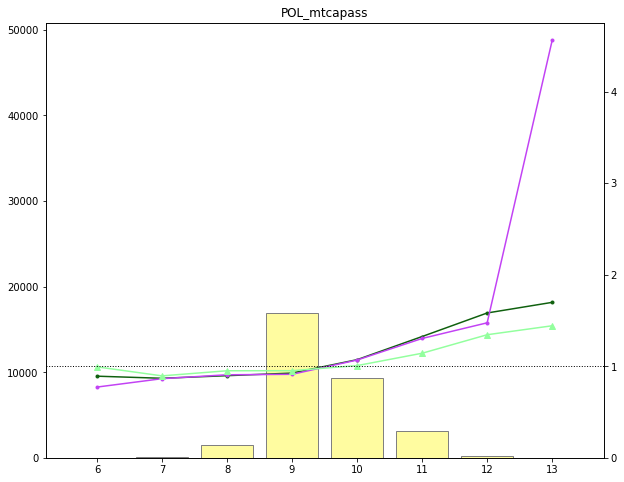

data/mrh/nbsinDDE/relativity_POL_distrib.png


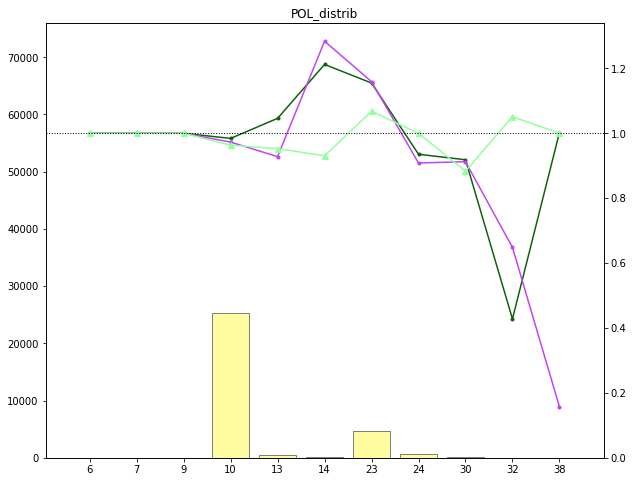

data/mrh/nbsinDDE/relativity_AUTV_prix_sra_supo.png


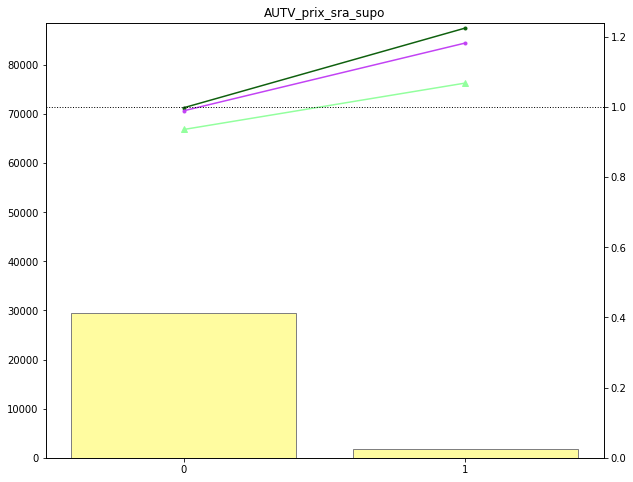

data/mrh/nbsinDDE/relativity_annee.png


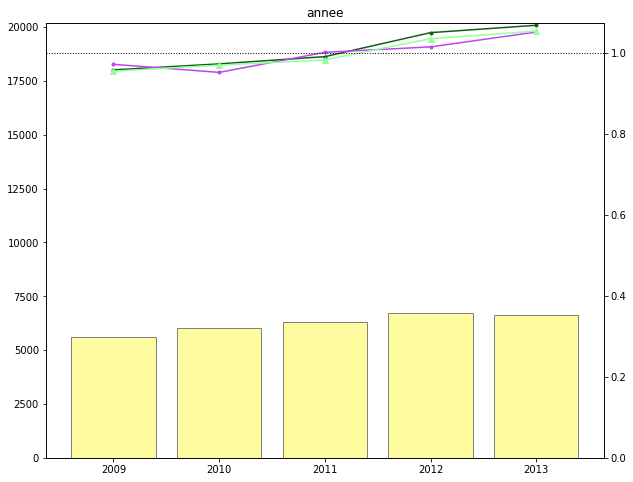

data/mrh/nbsinDDE/relativity_HAB_qual.png


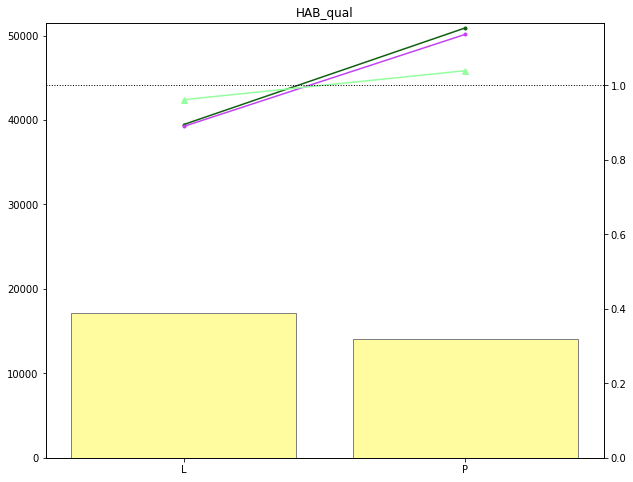

data/mrh/nbsinDDE/relativity_ddea_quant_cm_10.png


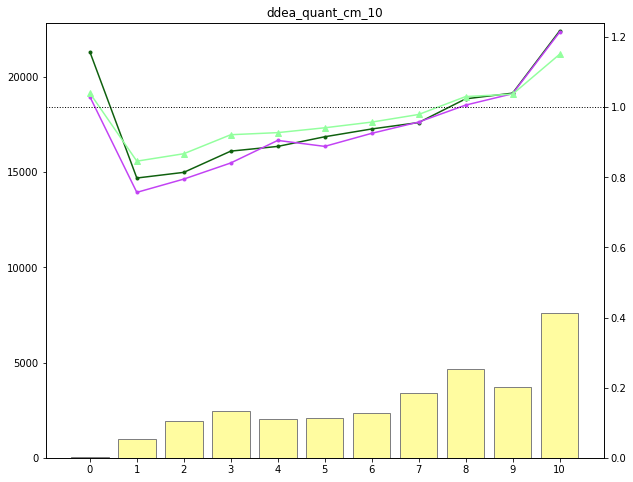

data/mrh/nbsinDDE/relativity_HAB_qual_inhab.png


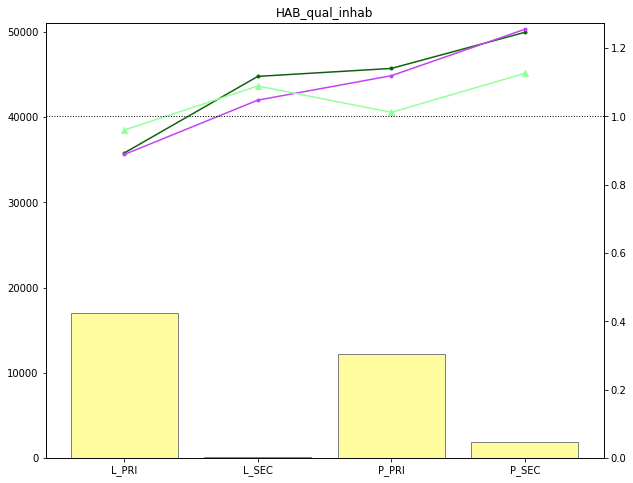

In [60]:
def fill_missing_modalities(df, modalities):
    for i in range(len(modalities)):
        if i not in df.index:
            df.loc[i] = [0, 1, 1]
            #df.loc[i].exposure = 0
            #df.loc[i].target = 1
            #df.loc[i].prediction = 1
    return df
    

def plot_relativities(df, model, feature, idx, modalities):
    try:
        modalities = [float(m) for m in modalities]
        if sum([m - int(m) for m in modalities]) == 0:
            modalities = [int(m) for m in modalities]
    except:
        pass
    
    df['f'] = test_data[:, idx]

    m = df.target.mean()
    relativity = df.groupby(['f']).agg({'exposure': 'sum', 'target': 'mean', 'prediction': 'mean'})
    relativity.target /= m
    relativity.prediction /= m
    relativity = fill_missing_modalities(relativity, modalities)
    relativity['modalities'] = modalities
    relativity['one'] = 1
    relativity['coeffs'] = get_coeffs(metadata.get_feature_range(feature))
    if(relativity['coeffs'].sum() == relativity['coeffs'].count()):
        return
    relativity = relativity.sort_values('modalities')
    size = relativity.prediction.size
    ar = np.arange(size)
    
    max_exposure = relativity.exposure.max()
    
    fig, ax1 = plt.subplots(figsize=(10, 8))

    ax1.bar(ar, relativity.exposure, color='#fffca0', edgecolor='grey')
    ax1.set_ylim(ymax=max_exposure * 3)
    ax1.set_xticks(ar)
    ax1.set_xticklabels(labels=relativity.modalities)
  
    ax2 = ax1.twinx()
    ax2.set_title(feature)
    ax2.plot(ar, relativity.prediction, color="#0f600e", marker=".")
    ax2.plot(ar, relativity.target, color="#c242f4", marker=".")
    ax2.plot(ar, relativity.coeffs, color="#93ff9e",marker="^")
    ax2.axhline(y=1, color='black', linewidth=1, linestyle="dotted")
    ax2.set_ylim(ymin=0)
    
    print(os.path.join(metadata.path, metadata.name, model, 'relativity_' + feature +'.png'))
    plt.savefig(os.path.join(metadata.path, metadata.name, model, 'relativity_' + feature +'.png'))
    plt.show()
    
for f in metadata.features:
    #try:
    calculate_relativities(df, model, f, metadata.get_feature_index(f), metadata.get_modalities(f))
    #except Exception as e:
        #print('Error ploting relativity chart for ', f)
        #print(e)

In [75]:
import results
from importlib import reload
reload(results)

r = results.Results(model, "data", "mrh")

Loaded metadata from  data/mrh/metadata.json
Saving relativity chart :  data/mrh/chargeDDEa/relativity_POL_mtcapass.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_superficie_m2_num.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_dens_pop.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_respr_1p.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_respr_5p.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_secocc.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_surf_inf40.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_surf_plus100.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_rev_15K29k.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_men_lochlm.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_men_pror.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_EXT_part_pop_18

Saving relativity chart :  data/mrh/chargeDDEa/relativity_HAB_qual.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_POL_ran.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_atr.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_aup.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_bqe.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_epa.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_hab.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_mot.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_mrp.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_pf.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_pju.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_prv.png
Saving relativity chart :  data/mrh/chargeDDEa/relativity_CLI_top_san.png
Saving relativity chart :  data/mrh/chargeDDEa